In [1]:
from osgeo import ogr, gdal, osr
import pandas as pd
import shapely.wkt
import fiona
import json
import os
import base64
import numpy as np
from pathlib import Path
import boto3
from datacube import Datacube
from datacube.utils.geometry import CRS, Geometry, GeoBox
from datacube.testutils.io import native_geobox, native_load
from datacube.utils.dask import start_local_dask
import rioxarray as rioxr
import awswrangler as wr
from datetime import timedelta, datetime
import dask.dataframe as dd
import matplotlib.pyplot as plt
import re

from datacube.utils.masking import make_mask

s3_obj = boto3.client('s3')
dc = Datacube()

/env/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(


In [2]:
ls98_fcp_paths = wr.s3.list_objects("s3://dea-public-data-dev/test/derivative/ga_ls_fc_pc_cyear_3/4-0-1/", suffix=[".json"])
ls8_fcp_paths = wr.s3.list_objects("s3://dea-public-data-dev/test/derivative/ga_ls_fc_pc_cyear_3/4-0-0/", suffix=[".json"])

In [3]:
ls98_fcp_paths_2023 = [x for x in ls98_fcp_paths if '2023--P1Y' in x]
ls8_fcp_paths_2023 = [x for x in ls8_fcp_paths if '2023--P1Y' in x]

In [4]:
ls98_fcp_paths_2022 = [x for x in ls98_fcp_paths if '2022--P1Y' in x]
ls8_fcp_paths_2022 = [x for x in ls8_fcp_paths if '2022--P1Y' in x]

In [33]:
print("Missing tiles:", set(ls98_ds) - set(ls8_ds))

Missing tiles: {'x53y49', 'x54y42', 'x49y40', 'x54y27', 'x53y52'}


In [6]:
pattern = r'\/x\d+\/y\d+\/'

def tile_ids_from_path(ds_paths):
    tiles = []
    
    for s in ds_paths:
        # Search for the pattern in the string
        match = re.search(pattern, s)

        if match:
            tile_id = match.group(0).replace("/","")
            tiles.append(tile_id)
    return tiles

In [7]:
ls98_ds_2023 = tile_ids_from_path(ls98_fcp_paths_2023)
ls8_ds_2023 = tile_ids_from_path(ls8_fcp_paths_2023)

ls98_ds_2022 = tile_ids_from_path(ls98_fcp_paths_2022)
ls8_ds_2022 = tile_ids_from_path(ls8_fcp_paths_2022)

In [8]:
cmn_tiles_2022 = set(ls98_ds_2022).intersection(set(ls8_ds_2022))
cmn_tiles_2023 = set(ls98_ds_2023).intersection(set(ls8_ds_2023))

In [9]:
def native_load_dss(dss, base_ds, measurements=None):
    geobox = native_geobox(
            base_ds, basis=list(dss[0].measurements.keys())[0]
        )
    mm = dss[0].type.lookup_measurements(measurements)
    tmp_data = dc.load_data(dc.group_datasets(dss, 'time'),
                    geobox, measurements=mm, dask_chunks={'time': 1, 'x': -1, 'y': -1})
        
    return tmp_data

In [10]:
# from datacube.utils import masking
# import dask.array as da
# from odc.algo import enum_to_bool, erase_bad

# results = {}
# nomatch_count = 0

# for band in ['pv_pc_10', 'pv_pc_50', 'pv_pc_90']:
#     diffs = []
    
#     for a in cmn_tiles:     
#         ls8_ds = wr.s3.list_objects("s3://dea-public-data-dev/test/derivative/ga_ls_fc_pc_cyear_3/4-0-0/"+
#                                           a[0:3]+"/"+a[3:], suffix=[".json"])[0]
#         ls89_ds = wr.s3.list_objects("s3://dea-public-data-dev/test/derivative/ga_ls_fc_pc_cyear_3/4-0-1/"+
#                                           a[:3]+"/"+a[3:], suffix=[".json"])[0]

#         s3_clientobj_ls8 = s3_obj.get_object(Bucket='dea-public-data-dev', Key=ls8_ds.removeprefix("s3://dea-public-data-dev/"))
#         s3_clientdata_ls8 = s3_clientobj_ls8['Body'].read().decode('utf-8')

#         s3_clientobj_ls89 = s3_obj.get_object(Bucket='dea-public-data-dev', Key=ls89_ds.removeprefix("s3://dea-public-data-dev/"))
#         s3_clientdata_ls89 = s3_clientobj_ls89['Body'].read().decode('utf-8')

#         load_path_ls8 = json.loads(s3_clientdata_ls8)["assets"][band]['href']                                       
#         ls8_fcp_data = rioxr.open_rasterio(load_path_ls8) 
#         load_path_ls89 = json.loads(s3_clientdata_ls89)["assets"][band]['href']                                       
#         ls89_fcp_data = rioxr.open_rasterio(load_path_ls89) 
        
#         ls8_band_data = ls8_fcp_data[0].where(ls8_fcp_data[0] != 255)
#         ls89_band_data = ls89_fcp_data[0].where(ls89_fcp_data[0] != 255)
        
#         diff = ls8_band_data - ls89_band_data
#         mean_diff = np.nanmean(diff),
#         diffs.append(mean_diff)
#     results.update({band: diffs})

In [11]:
def plot_percentile(band, n, prc_10, prc_50, prc_90):
    plt.figure(figsize=(10, 15))

    x_values = np.arange(len(prc_10))
    plt.subplot(n, 3, 1)
    plt.plot(x_values, prc_10, 'ro', label=f'PC-10 {band}')
    plt.title('PC-10')

    x_values = np.arange(len(prc_50))
    plt.subplot(n, 3, 2)
    plt.plot(x_values, prc_50, 'go', label=f'PC-50 {band}')
    plt.title('PC-50')

    x_values = np.arange(len(prc_90))
    plt.subplot(n, 3, 3)
    plt.plot(x_values, prc_90, 'bo', label=f'PC-90 {band}')    
    plt.title('PC-90')    
    plt.subplots_adjust(top=0.95)
    
    plt.suptitle(f'{band}')
    # plt.savefig(f'{a[0]}_PV.png')

    plt.show()    

In [12]:
year = 2022


from datacube.utils import masking
import dask.array as da
from odc.algo import enum_to_bool, erase_bad
import multiprocessing

# Define a function to compute the diff for a single tile
def compute_diff(a, band, year):    
    ls8_ds = wr.s3.list_objects("s3://dea-public-data-dev/test/derivative/ga_ls_fc_pc_cyear_3/4-0-0/"+
                                a[0:3]+"/"+a[3:]+f"/{year}--P1Y", suffix=[".json"])[0]
    ls89_ds = wr.s3.list_objects("s3://dea-public-data-dev/test/derivative/ga_ls_fc_pc_cyear_3/4-0-1/"+
                                 a[:3]+"/"+a[3:]+f"/{year}--P1Y", suffix=[".json"])[0]

    s3_clientobj_ls8 = s3_obj.get_object(Bucket='dea-public-data-dev', Key=ls8_ds.removeprefix("s3://dea-public-data-dev/"))
    s3_clientdata_ls8 = s3_clientobj_ls8['Body'].read().decode('utf-8')

    s3_clientobj_ls89 = s3_obj.get_object(Bucket='dea-public-data-dev', Key=ls89_ds.removeprefix("s3://dea-public-data-dev/"))
    s3_clientdata_ls89 = s3_clientobj_ls89['Body'].read().decode('utf-8')

    load_path_ls8 = json.loads(s3_clientdata_ls8)["assets"][band]['href']                                       
    ls8_fcp_data = rioxr.open_rasterio(load_path_ls8) 
    load_path_ls89 = json.loads(s3_clientdata_ls89)["assets"][band]['href']                                       
    ls89_fcp_data = rioxr.open_rasterio(load_path_ls89) 

    ls8_band_data = ls8_fcp_data[0].where(ls8_fcp_data[0] != 255)
    ls89_band_data = ls89_fcp_data[0].where(ls89_fcp_data[0] != 255)

    diff = ls8_band_data - ls89_band_data
    mean_diff = np.nanmean(diff)
    return mean_diff

def run_fcp_cmp(fc_band):
    # Specify the number of cores
    
    num_cores = multiprocessing.cpu_count()
    print(num_cores)
    # Create a multiprocessing pool with specified number of processes
    pool = multiprocessing.Pool(processes=num_cores)

    results = {}
    nomatch_count = 0

    for band in [f'{fc_band}_pc_10', f'{fc_band}_pc_50', f'{fc_band}_pc_90']:
        diffs = []

        # Use multiprocessing to compute diffs for each tile in parallel
        for a in cmn_tiles_2022:
            diffs.append(pool.apply_async(compute_diff, (a, band, 2022)))

        # Get the computed results
        diffs = [diff.get() for diff in diffs]

        results[band] = diffs

    # Close the multiprocessing pool
    pool.close()
    pool.join()
    return results

In [13]:
pv_results = run_fcp_cmp('pv')
npv_results = run_fcp_cmp('npv')
bs_results = run_fcp_cmp('bs')

64
64
64


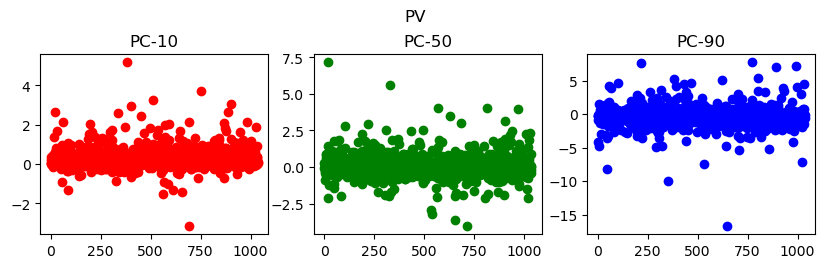

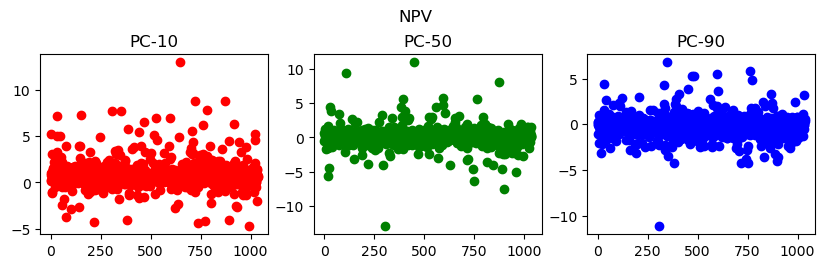

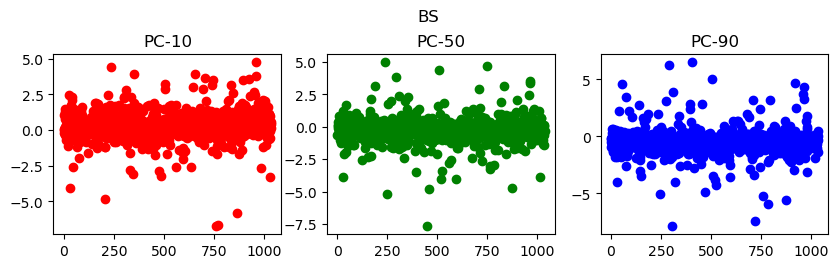

In [15]:
n = 6
plot_percentile("PV", n, pv_results.get('pv_pc_10'), pv_results.get('pv_pc_50'), pv_results.get('pv_pc_90'))
plot_percentile("NPV", n, npv_results.get('npv_pc_10'), npv_results.get('npv_pc_50'), npv_results.get('npv_pc_90'))
plot_percentile("BS", n, bs_results.get('bs_pc_10'), bs_results.get('bs_pc_50'), bs_results.get('bs_pc_90'))